# Base Model Training

setup dataloaders, loss, optimizer, execute training loop, output curves to tensorboard, view results via tensorboard

TODO: <br>
1) Get working completely


In [1]:
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import time
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import ntpath
import collections
import shutil

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

/home/jared/miniconda3/envs/speed_detection/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
DATA_PATH = Path('../data/').resolve()
TRAIN_VIDEO = DATA_PATH/'train.mp4'
TEST_VIDEO = DATA_PATH/'test.mp4'
CLEAN_DATA_PATH = Path('../data/').resolve()

TRAIN_PATH = DATA_PATH/'train'
VAL_PATH = DATA_PATH/'val'
TEST_PATH = DATA_PATH/'test'
HOLDOUT_PATH = DATA_PATH/'holdout'

MODEL_PATH = Path('../models/').resolve()

# Training Parameters

In [3]:
seed = 42

# hyperparameters
input_width = 6
label_width = 3
shift = 3
batch_size = 2*torch.cuda.device_count()
num_epochs = 50 

# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# Loading Meta dataset

In [4]:
train_meta = pd.read_csv(TRAIN_PATH/'train_meta.csv')
print('shape: ', train_meta.shape)
val_meta = pd.read_csv(VAL_PATH/'val_meta.csv')
print('shape: ', val_meta.shape)
holdout_meta = pd.read_csv(HOLDOUT_PATH/'holdout_meta.csv')
print('shape: ', holdout_meta.shape)

shape:  (14280, 3)
shape:  (4080, 3)
shape:  (2040, 3)


In [5]:
train_ids = train_meta['image_index'].values
val_ids = val_meta['image_index'].values
holdout_ids = holdout_meta['image_index'].values

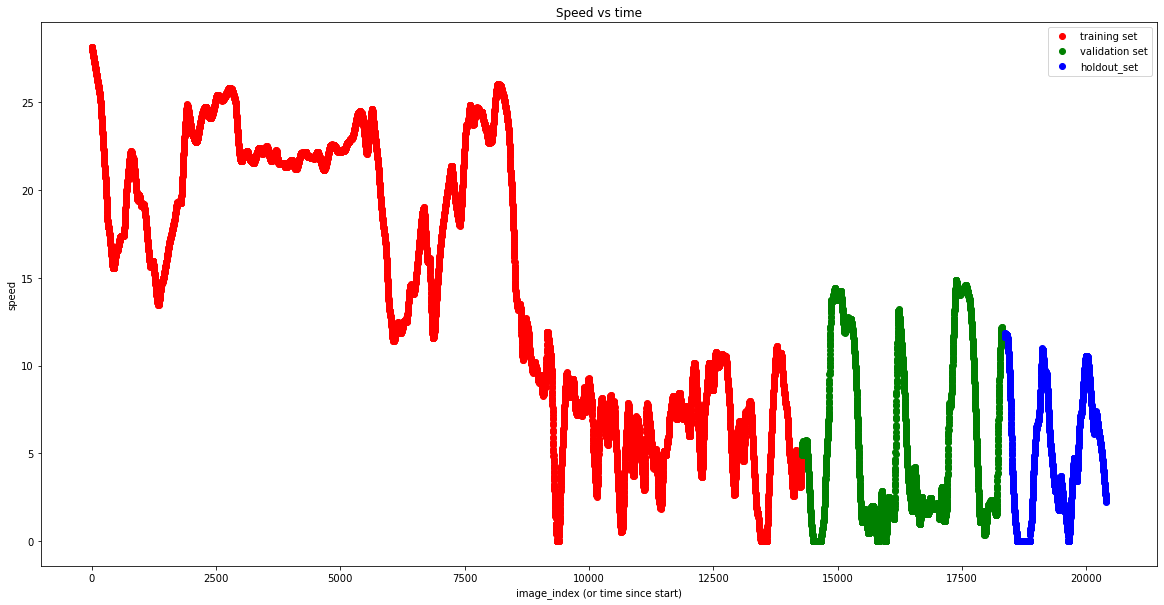

----
train_data:  14280
valid_data:  4080


In [6]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_ids, train_meta['speed'], 'ro')
plt.plot(val_ids, val_meta['speed'], 'go')
plt.plot(holdout_ids, holdout_meta['speed'], 'bo')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set', 'holdout_set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('train_data: ', len(train_ids))
print('valid_data: ', len(val_ids))

# Data setup: transformations, Dataset, Dataloader

In [7]:
def open_image_from_path(image_path):
    """
    returns image as numpy array (H, W, RGB)
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
"""
Some image augmentation methods, applied to the 2 frames before optical flow is calculated:

"""

class Crop(object):
    """
        input: image (480 (y), 640 (x), 3) RGB
        output: image (shape is (220, 570, 3) as RGB)
    """
    def __call__(self, frame):
        # Crop out sky (top) (100px) and black right part (-90px)
        frame = frame[130:350, 35:605]#[25:375, :]

        return frame
    
    
class GaussianBlur(object):
    """
    Apply cv2 gaussian blur for image smoothing
    """
    def __call__(self, frame):
        frame = cv2.GaussianBlur(frame, (3,3), 0)
            
        return frame


In [9]:
"""
Some image augmentation methods, applied to the 2 frames before optical flow is calculated:

"""
class RandomBrightness(object):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    def __init__(self):
        self.bright_factor = 1 + np.clip(np.random.normal(loc=0, scale=.3), -.5, .5)
        global temp
        temp = self.bright_factor
        
    def __call__(self, frame):        
        new_bright_factor = self.bright_factor + np.clip(np.random.normal(loc=0, scale=.05), -.15, .15)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        # perform brightness augmentation only on the second channel
        if new_bright_factor < 1:
            frame[:,:,2] = frame[:,:,2] * new_bright_factor
        else:
            temp_bright_factor = 2-new_bright_factor 
            frame[:,:,2] = frame[:,:,2]*temp_bright_factor+(1-temp_bright_factor)*255
        # change back to RGB
        return cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)
                

class RICAP(object):
    """
    http://proceedings.mlr.press/v95/takahashi18a/takahashi18a.pdf
    
    """
    def __init__(self, beta):
        self.beta = beta
        self.x1 = None
        self.y1 = None
        self.I_y = None
        self.I_x = None
        self.w1 = None
        self.h1 = None
        
    def __call__(self, frame):
        beta = self.beta  # hyperparameter
        
        if self.x1 == None:
            # size of image
            self.I_y, self.I_x, _ = frame.shape

            # generate boundary position (w, h)
            self.x1 = int(np.round(self.I_x * np.random.beta(beta, beta)))
            self.y1 = int(np.round(self.I_y * np.random.beta(beta, beta)))

            self.w1 = int(np.random.uniform(low=50, high=200, size=None))
            self.h1 = int(np.random.uniform(low=50, high=100, size=None))
        
        cropper = np.zeros_like(sample['frame1'][self.y1:min(self.I_y, self.y1 + self.h1), 
                                                 self.x1:min(self.I_x, self.x1 + self.w1), :])

        frame[self.y1:min(self.I_y, self.y1 + self.h1), 
              self.x1:min(self.I_x, self.x1 + self.w1), :] = cropper
    
        return frame

In [10]:
class ToTensor(object):
    """
    Convert ndarray to Tensor.
    """
    
    def __call__(self, frame):
        """
        Convert ndarrays in sample to Tensors.
        """
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return torch.from_numpy(frame.transpose((2, 0, 1))).type(dtype)
    
class ToNumpy(object):
    """
    Convert image Tensor arrays to np arrays
    """
    
    def __call__(self, tensor):
        """
        Convert ndarrays in sample to Tensors.
        """
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return tensor.cpu().permute(1, 2, 0).numpy()

In [11]:
class SequentialDataset(Dataset):
    """Dataset for treating image inputs as time series."""

    def __init__(self, csv_file, root_dir, overwrite_cropped, input_width, label_width, shift,
                 pre_crop_transforms, post_crop_transforms = None, 
                 ):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory to create cropped_images folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.cropped_dir = root_dir/"cropped_images"
        self.overwrite_cropped = overwrite_cropped
        self.pre_crop_transforms = pre_crop_transforms
        self.post_crop_transforms  = post_crop_transforms
        self.transforms = transforms
        
        self._crop_images(csv_file)
        
        #window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
    def _crop_images(self, csv_file):
        os.makedirs(self.cropped_dir, exist_ok=True)
        if(self.overwrite_cropped == False):
            new_df = pd.read_csv(self.root_dir/f'{str(csv_file)[:-4]}_cropped.csv')
            
            cur_cropped = [f for f in os.listdir(self.cropped_dir) if f.endswith('.jpg')]
            cropped_paths = new_df['cropped_path'].apply(ntpath.basename).values
            
            if collections.Counter(self.df['image_path'].values) != collections.Counter(new_df['image_path'].values):
                raise ValueError("Overwrite set to false, but old and new dataframe do not match")
            if collections.Counter(cur_cropped) != collections.Counter(cropped_paths):
                raise ValueError("Overwrite set to false, but Dataframe and current images saved do not match")
 
            self.df = new_df
            return
    
        #delete all files
        all_paths = [os.path.join(self.cropped_dir, f) for f in os.listdir(self.cropped_dir) if f.endswith(".jpg") ]
        for f in all_paths:
            os.remove(f)
    
        names = []
        for idx in range(0, self.df.shape[0]):
            frame, path = self._get_frame(idx)
            
            #save as rgb
            basename = ntpath.basename(path)
            save_path = str(self.cropped_dir/basename)
            cv2.imwrite(save_path, frame)
            names += [save_path]
    
        #save paths to df
        self.df['cropped_path'] = names
        csv_name = ntpath.basename(csv_file)
        self.df.to_csv(self.root_dir/f'{str(csv_file)[:-4]}_cropped.csv', index=False)
    
    def __len__(self):
        return (len(self.df) - self.input_width + 1)//self.shift

    def _get_frame(self, idx):
        """
        returns the frame for the given index
        
        """
        frame_name = self.df.iloc[idx]['image_path']
        frame = open_image_from_path(frame_name) 
        if self.pre_crop_transforms:
            frame = self.pre_crop_transforms(frame)
            
        return frame, frame_name
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        input_slice = slice(idx*self.shift, idx*self.shift + self.input_width)
        input_indices = np.arange(input_slice.start + self.input_width)[input_slice]

        labels_slice = slice(input_slice.stop - self.label_width, input_slice.stop)
        label_indices = np.arange(input_slice.start + self.input_width)[labels_slice]

        
        #read in rgb
        sample = {'images': [cv2.imread(x) for x in self.df.iloc[input_indices]['cropped_path'].values],
                  'targets': self.df.iloc[label_indices]['speed'].values}

        if self.post_crop_transforms:
            sample['images'] = [self.post_crop_transforms(x) for x in sample['images']]
            
        sample['images'] = torch.stack(sample['images'])
        sample['targets'] = torch.tensor(sample['targets']).type(dtype)
        
        return sample

#### initializing dataset

In [12]:
print("Initializing Datasets and Dataloaders...")
    
train_dataset = SequentialDataset(TRAIN_PATH/'train_meta.csv', 
                                TRAIN_PATH,
                                overwrite_cropped = False,
                                input_width = input_width, label_width = label_width, shift = shift,
                                pre_crop_transforms = transforms.Compose([Crop()]),
                                post_crop_transforms = transforms.Compose([GaussianBlur(), RandomBrightness(),
                                                                           ToTensor(),
                                                                           transforms.Normalize([59.45286, 74.15402, 91.471405],
                                                                                                [56.784863, 66.16346, 72.452065])
                                                                          ])
                               )
                        

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print('train initialized')

val_dataset = SequentialDataset(VAL_PATH/'val_meta.csv', 
                                VAL_PATH,
                                overwrite_cropped = False,
                                input_width = input_width, label_width = label_width, shift = shift,
                                pre_crop_transforms = transforms.Compose([Crop()]),
                                post_crop_transforms = transforms.Compose([ToTensor(),
                                                                           transforms.Normalize([59.45286, 74.15402, 91.471405],
                                                                                                [56.784863, 66.16346, 72.452065])
                                                                          ])
                               )

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print('val initialized')

Initializing Datasets and Dataloaders...
train initialized
val initialized


In [13]:
#computing normalization values:
"""pop_mean = []
pop_std0 = []
pop_std1 = []
for i, data in enumerate(train_dataloader, 0):
    # shape (batch_size, input_width, 3, height, width)
    # reshape to (batch_size*input_width, 3, height, width)
    data['images'] = torch.flatten(data['images'], 0, 1)

    if device.type == 'cuda':
        numpy_image = data['images'].cpu().numpy()
    else:
        numpy_image = data['images'].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
print('mean;std0;std1')
print(list(np.array(pop_mean).mean(axis=0)), sep=', ')
print(list(np.array(pop_std0).mean(axis=0)), sep=', ')
print(list(np.array(pop_std1).mean(axis=0)), sep=', ')"""

#precomputed values:
print('mean;std0;std1')
print('''[59.45286, 74.15402, 91.471405]
[56.784863, 66.16346, 72.452065]
[56.784866, 66.16347, 72.45207]
''')

mean;std0;std1
[59.45286, 74.15402, 91.471405]
[56.784863, 66.16346, 72.452065]
[56.784866, 66.16347, 72.45207]



#### visualizing flow

#### Before and after

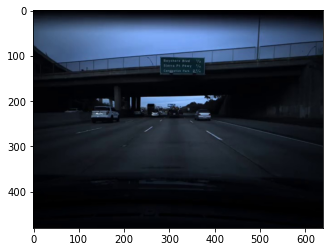

In [14]:
temp = cv2.imread(train_dataset.df.iloc[0]['image_path'])

plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))

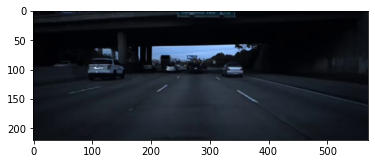

In [15]:
sample, _ = train_dataset._get_frame(0)
plt.imshow(sample)

#### iterating through model inputs

In [16]:
it = iter(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


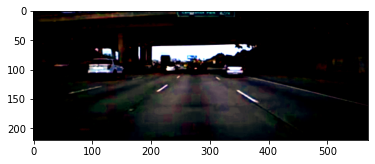

In [17]:
plt.imshow(ToNumpy()(next(it)['images'][0]))

# Training Setup: Model, Optimizer, Loss, Epochs, TensorBoard


In [18]:
import sys

detr_path = Path('../models/detr').resolve()

if not str(detr_path) in sys.path:
    sys.path.append(str(detr_path))
    
from models import build_args
from models import build_model
import util.misc
import random

%load_ext autoreload
%autoreload 2

In [19]:
args = build_args()

In [20]:
if args.frozen_weights is not None:
    assert args.masks, "Frozen training is meant for segmentation only"

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + util.misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model, criterion = build_model(args)
model.to(device)

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Drop

In [21]:
for data in train_dataloader:
    break
    
inputs = data['images']
targets = data['targets']
    
tensor_list = inputs
tensor_list = tensor_list.reshape((tensor_list.shape[0] * tensor_list.shape[1], 
                                   tensor_list.shape[2], tensor_list.shape[3], tensor_list.shape[4]))
tensor_list = util.misc.nested_tensor_from_tensor_list(tensor_list)


In [22]:
tensor_list.tensors.shape

torch.Size([48, 3, 220, 570])

In [23]:
inputs.shape

torch.Size([8, 6, 3, 220, 570])

In [ ]:
model.backbone(inputs)

> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(35)forward()
     33         pdb.set_trace()
     34 
---> 35         assert mask is not None
     36         not_mask = ~mask
     37         y_embed = not_mask.cumsum(1, dtype=torch.float32)

ipdb> l
     30         mask = tensor_list.mask
     31 
     32         import pdb
     33         pdb.set_trace()
     34 
---> 35         assert mask is not None
     36         not_mask = ~mask
     37         y_embed = not_mask.cumsum(1, dtype=torch.float32)
     38         x_embed = not_mask.cumsum(2, dtype=torch.float32)
     39         if self.normalize:
     40             eps = 1e-6

ipdb> x
tensor([[[[0.0000e+00, 0.0000e+00, 3.9253e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.3271e-02,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1494e-01,
           0.0000e+00, 0.0000e+00],
          ...,
    

ipdb> x.shape
torch.Size([48, 2048, 7, 18])
ipdb> mask.shape
torch.Size([48, 7, 18])
ipdb> x.head
*** AttributeError: 'Tensor' object has no attribute 'head'
ipdb> x[0]
tensor([[[0.0000, 0.0000, 0.0393,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0933, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6149, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0095,  ..., 0.0000, 0.0000, 0.3635],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0764, 0.1558],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0338]],

        [[0.0000, 0.0168, 0.0000,  ..., 0.0000, 0.0000, 0.2729],
         [0.2706, 0.1152, 0.4518,  ..., 0.3945, 0.6177, 0.3390],
         [0.3619, 0.5573, 0.5265,  ..., 0.0000, 0.6173, 0.1934],
         ...,
         [0.0000, 0.4537, 0.6160,  ..., 0.4707, 0.8010, 0.2843],
         [0.0000, 0.0000, 0.1772,  ..., 0.2075, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2518, 0.0000, 0.0000]],

        [[0.8305, 0

ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(38)forward()
     36         not_mask = ~mask
     37         y_embed = not_mask.cumsum(1, dtype=torch.float32)
---> 38         x_embed = not_mask.cumsum(2, dtype=torch.float32)
     39         if self.normalize:
     40             eps = 1e-6

ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(39)forward()
     37         y_embed = not_mask.cumsum(1, dtype=torch.float32)
     38         x_embed = not_mask.cumsum(2, dtype=torch.float32)
---> 39         if self.normalize:
     40             eps = 1e-6
     41             y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale

ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(40)forward()
     38         x_embed = not_mask.cumsum(2, dtype=torch.float32)
     39         if self.normalize:
---> 40             eps = 1e-6
     41             y_embed = y_embed / (y_embed[:, -1:, 

ipdb> dim_t.shape
torch.Size([128])
ipdb> dim_t[10]
tensor(10., device='cuda:0')
ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(47)forward()
     45         dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
     46 
---> 47         pos_x = x_embed[:, :, :, None] / dim_t
     48         pos_y = y_embed[:, :, :, None] / dim_t
     49         pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)

ipdb> dim_t
tensor([1.0000e+00, 1.0000e+00, 1.1548e+00, 1.1548e+00, 1.3335e+00, 1.3335e+00,
        1.5399e+00, 1.5399e+00, 1.7783e+00, 1.7783e+00, 2.0535e+00, 2.0535e+00,
        2.3714e+00, 2.3714e+00, 2.7384e+00, 2.7384e+00, 3.1623e+00, 3.1623e+00,
        3.6517e+00, 3.6517e+00, 4.2170e+00, 4.2170e+00, 4.8697e+00, 4.8697e+00,
        5.6234e+00, 5.6234e+00, 6.4938e+00, 6.4938e+00, 7.4989e+00, 7.4989e+00,
        8.6596e+00, 8.6596e+00, 1.0000e+01, 1.0000e+01, 1.1548e+01, 1.1548e+01,
        1.3

torch.Size([48, 7, 18, 128])
ipdb> pos_y.shape
torch.Size([48, 7, 18, 128])
ipdb> 
torch.Size([48, 7, 18, 128])
ipdb> x.shape
torch.Size([48, 2048, 7, 18])
ipdb> pos_x[:, :, :, 0:2].shape
torch.Size([48, 7, 18, 2])
ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(50)forward()
     48         pos_y = y_embed[:, :, :, None] / dim_t
     49         pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
---> 50         pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
     51         pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
     52         return pos

ipdb> n
> /home/jared/Research/speed_detection/models/detr/models/position_encoding.py(51)forward()
     49         pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
     50         pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()

In [49]:
def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

In [50]:
tensor_list = inputs

In [51]:
max_size = _max_by_axis([list(img.shape) for img in tensor_list])

In [52]:
max_size

[6, 3, 220, 570]

In [54]:
batch_size

8

In [55]:
type(inputs)

torch.Tensor

In [53]:
inputs.shape

torch.Size([8, 6, 3, 220, 570])

In [ ]:
util.misc.nested_tensor_from_tensor_list()

torch.Size([48, 3, 220, 570])

In [60]:
(inputs.shape[0] * inputs.shape[1]) + (inputs.shape[2:])

TypeError: unsupported operand type(s) for +: 'int' and 'torch.Size'

In [ ]:
()

In [34]:
# run specific constants
model_name = 'efficientnet-b4'
run_name = '{}-batch={}-epochs={}'.format(model_name,batch_size, num_epochs)

model_filepath = os.path.join(MODEL_PATH, run_name)
os.makedirs(model_filepath, exist_ok=True)
tensorboard_loc = os.path.join(model_filepath, 'tensorboard')
writer = SummaryWriter(tensorboard_loc)
shutil.copyfile('dense_flow_deep_learning.ipynb', os.path.join(model_filepath, 'nb_backup.ipynb'))

'/home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/nb_backup.ipynb'

In [35]:
#model = EfficientNet.from_pretrained(f'{model_name}')
model = EfficientNet.from_name(f'{model_name}')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

start_epoch = 0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

if device.type == 'cuda':
    if torch.cuda.device_count() > 1:
        gpu_ids = list(range(torch.cuda.device_count()))
        model = nn.DataParallel(model, device_ids=gpu_ids)

for param in model.parameters():
    param.requires_grad = True
        
model.to(device)

DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [36]:
load_checkpoint = False

if load_checkpoint == True:
    print('loading checkpoint')
    #change to your model checkpoint loc
    checkpoint_path = Path("../models/efficientnet-b4-batch=20-epochs=50/model_30.pt").resolve()
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']

# PyTorch Training Loop

In [37]:
train_log_iters = len(train_dataloader) // 40
val_log_iters = len(train_dataloader) // 3

print(f'Number of epochs: {num_epochs}')
print(f'Batches per epoch: {len(train_dataloader)}')
print(f'train logging frequency: {train_log_iters}')
print(f'validation logging frequency: {val_log_iters}')

Number of epochs: 50
Batches per epoch: 714
train logging frequency: 17
validation logging frequency: 238


In [ ]:
train = True

if train == True:
    print(f'Batches per epoch: {len(train_dataloader)}')
    epoch_loss = None
    
    
    for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
        """
        Start new epoch
        """
        print(f'-----------------starting epoch {epoch}-----------------')
        full_running_loss = 0.0
        running_loss = 0.0
        model.train()

        for i, data in enumerate(train_dataloader, 0):
            """
            Batch operations
            """
            torch.cuda.synchronize()
            since = int(round(time.time()*1000))

            # get the inputs; data is a dict
            inputs = data['image']
            labels = data['speed']

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.reshape(outputs.size()[0])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            full_running_loss += loss.item()

            time_elapsed = int(round(time.time()*1000)) - since
            writer.add_scalar('WallTime/Train Batch (ms)', time_elapsed, epoch * len(train_dataloader) + i) 

            #print(running_loss)

            """
            Train metrics logging
            """
            if i % train_log_iters == train_log_iters - 1:    # every train_log_iters mini-batches... 
                # log the running loss
                writer.add_scalar(f'Loss/Train MSE, {train_log_iters} batches',
                                running_loss / train_log_iters,
                                epoch * len(train_dataloader) + i)    

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                '''writer.add_figure('predictions vs. actuals',
                                plot_classes_preds(net, inputs, labels),
                                global_step=epoch * len(trainloader) + i)'''


                print(f'batch {i}, train loss: {running_loss}, wall time: {time_elapsed} ms')
                running_loss = 0.0

            """
            Val metrics logging
            """
            if i % val_log_iters == val_log_iters - 1:    # every val_log_iters mini-batches...
                torch.cuda.synchronize()
                since = int(round(time.time()))

                #get validation loss:
                model.eval()
                val_loss = 0.0
                for j, data in enumerate(val_dataloader, 0):
                    with torch.no_grad():
                        inputs = data['image']
                        labels = data['speed']

                        # forward + backward + optimize
                        outputs = model(inputs)
                        outputs = outputs.reshape(outputs.size()[0])
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()

                val_loss = val_loss / len(val_dataloader)
                # log the validation loss
                writer.add_scalar('Loss/Validation MSE',
                                  val_loss,
                                  epoch * len(train_dataloader) + i)

                time_elapsed = int(round(time.time())) - since
                writer.add_scalar('WallTime/Validation Set (s)', time_elapsed, epoch * len(train_dataloader) + i) 

                model.train()
                print(f'** validation MSE: {val_loss}, wall time: {time_elapsed} s**')

        """
        End of Epoch
        """
        if epoch_loss == None or full_running_loss < epoch_loss:
            epoch_loss  = full_running_loss
            checkpoint_path = os.path.join(model_filepath, f'model_{epoch}.pt')
            print(f'saving checkpoint as: {checkpoint_path}')
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_loss': full_running_loss,
                        'val_loss': val_loss,
                        }, checkpoint_path)

        full_running_loss = full_running_loss / len(train_dataloader)
        writer.add_scalar(f'Epoch Loss/Train MSE', full_running_loss, epoch)    
        writer.add_scalar(f'Epoch Loss/Val MSE', val_loss, epoch)    
        
        full_running_loss = 0
    print('Finished Training')
    writer.close()

Batches per epoch: 714
-----------------starting epoch 0-----------------
batch 16, train loss: 3512.487014770508, wall time: 271 ms
batch 33, train loss: 1899.6456413269043, wall time: 207 ms
batch 50, train loss: 1077.9685096740723, wall time: 204 ms
batch 67, train loss: 899.8013801574707, wall time: 209 ms
batch 84, train loss: 782.2970581054688, wall time: 206 ms
batch 101, train loss: 721.8606033325195, wall time: 273 ms
batch 118, train loss: 727.8412923812866, wall time: 270 ms
batch 135, train loss: 593.2804050445557, wall time: 204 ms
batch 152, train loss: 477.60377311706543, wall time: 205 ms
batch 169, train loss: 512.685263633728, wall time: 208 ms
batch 186, train loss: 493.4863910675049, wall time: 204 ms
batch 203, train loss: 475.20869064331055, wall time: 269 ms
batch 220, train loss: 449.6738586425781, wall time: 269 ms
batch 237, train loss: 452.69830989837646, wall time: 209 ms
** validation MSE: 26.057957441208192, wall time: 25 s**
batch 254, train loss: 398.703

batch 662, train loss: 102.29824721813202, wall time: 274 ms
batch 679, train loss: 70.6333556175232, wall time: 212 ms
batch 696, train loss: 119.911052942276, wall time: 206 ms
batch 713, train loss: 93.50149750709534, wall time: 206 ms
** validation MSE: 22.466910270353157, wall time: 26 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/model_2.pt
-----------------starting epoch 3-----------------
batch 16, train loss: 74.0945395231247, wall time: 208 ms
batch 33, train loss: 99.26725912094116, wall time: 216 ms
batch 50, train loss: 72.15428113937378, wall time: 214 ms
batch 67, train loss: 73.16907787322998, wall time: 209 ms
batch 84, train loss: 89.87228441238403, wall time: 267 ms
batch 101, train loss: 91.49281048774719, wall time: 206 ms
batch 118, train loss: 86.18505644798279, wall time: 207 ms
batch 135, train loss: 95.26204013824463, wall time: 207 ms
batch 152, train loss: 105.89185810089111, wall time: 205 ms
batch 

batch 577, train loss: 61.01516377925873, wall time: 207 ms
batch 594, train loss: 56.628353118896484, wall time: 207 ms
batch 611, train loss: 77.36055612564087, wall time: 208 ms
batch 628, train loss: 77.36968207359314, wall time: 206 ms
batch 645, train loss: 108.07099723815918, wall time: 276 ms
batch 662, train loss: 99.56791830062866, wall time: 269 ms
batch 679, train loss: 87.26158952713013, wall time: 208 ms
batch 696, train loss: 80.76740980148315, wall time: 206 ms
batch 713, train loss: 56.275967955589294, wall time: 218 ms
** validation MSE: 50.95413340204487, wall time: 25 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/model_5.pt
-----------------starting epoch 6-----------------
batch 16, train loss: 82.6081850528717, wall time: 209 ms
batch 33, train loss: 69.8722357749939, wall time: 208 ms
batch 50, train loss: 100.19603073596954, wall time: 208 ms
batch 67, train loss: 98.71220850944519, wall time: 209 ms
bat

batch 509, train loss: 57.61521649360657, wall time: 209 ms
batch 526, train loss: 48.473647713661194, wall time: 209 ms
batch 543, train loss: 66.88854157924652, wall time: 211 ms
batch 560, train loss: 48.175506234169006, wall time: 269 ms
batch 577, train loss: 47.74514836072922, wall time: 209 ms
batch 594, train loss: 43.82002466917038, wall time: 210 ms
batch 611, train loss: 43.45194584131241, wall time: 207 ms
batch 628, train loss: 44.120105385780334, wall time: 214 ms
batch 645, train loss: 49.588001132011414, wall time: 229 ms
batch 662, train loss: 38.16883593797684, wall time: 275 ms
batch 679, train loss: 44.65712469816208, wall time: 210 ms
batch 696, train loss: 60.30883812904358, wall time: 209 ms
batch 713, train loss: 55.80161273479462, wall time: 209 ms
** validation MSE: 45.064271369985505, wall time: 25 s**
saving checkpoint as: /home/jared/Research/speed_detection/models/efficientnet-b4-batch=20-epochs=50/model_8.pt
-----------------starting epoch 9--------------

batch 424, train loss: 58.33238273859024, wall time: 211 ms
batch 441, train loss: 41.15946698188782, wall time: 209 ms
batch 458, train loss: 56.40716505050659, wall time: 207 ms
batch 475, train loss: 51.903480648994446, wall time: 280 ms
** validation MSE: 38.94065483790987, wall time: 26 s**
batch 492, train loss: 42.249988198280334, wall time: 210 ms
batch 509, train loss: 36.5160471200943, wall time: 208 ms
batch 526, train loss: 36.43904250860214, wall time: 273 ms
batch 543, train loss: 31.89421898126602, wall time: 279 ms
batch 560, train loss: 36.67866212129593, wall time: 211 ms
batch 577, train loss: 46.00678038597107, wall time: 209 ms
batch 594, train loss: 46.203857362270355, wall time: 209 ms
batch 611, train loss: 40.638384222984314, wall time: 209 ms
batch 628, train loss: 30.31583708524704, wall time: 271 ms
batch 645, train loss: 28.025290608406067, wall time: 270 ms
batch 662, train loss: 36.409310936927795, wall time: 210 ms
batch 679, train loss: 51.1457473039627

batch 390, train loss: 23.222927510738373, wall time: 268 ms
batch 407, train loss: 26.34818994998932, wall time: 210 ms
batch 424, train loss: 23.55836033821106, wall time: 211 ms
batch 441, train loss: 33.915749192237854, wall time: 210 ms
batch 458, train loss: 40.442514061927795, wall time: 212 ms
batch 475, train loss: 37.85446226596832, wall time: 208 ms
** validation MSE: 62.20583544116394, wall time: 26 s**
batch 492, train loss: 37.20227998495102, wall time: 210 ms
batch 509, train loss: 37.9429395198822, wall time: 211 ms
batch 526, train loss: 39.690151274204254, wall time: 222 ms
batch 543, train loss: 21.623294353485107, wall time: 272 ms
batch 560, train loss: 26.020878612995148, wall time: 211 ms
batch 577, train loss: 27.37932175397873, wall time: 209 ms
batch 594, train loss: 29.75014352798462, wall time: 207 ms
batch 611, train loss: 27.97505670785904, wall time: 210 ms
batch 628, train loss: 32.08391851186752, wall time: 210 ms
batch 645, train loss: 25.4595173597335

batch 322, train loss: 22.841821253299713, wall time: 214 ms
batch 339, train loss: 17.395650684833527, wall time: 212 ms
batch 356, train loss: 22.513099998235703, wall time: 209 ms
batch 373, train loss: 14.774935811758041, wall time: 210 ms
batch 390, train loss: 17.53149402141571, wall time: 272 ms
batch 407, train loss: 38.80418562889099, wall time: 212 ms
batch 424, train loss: 26.489209979772568, wall time: 210 ms
batch 441, train loss: 23.878827393054962, wall time: 207 ms
batch 458, train loss: 29.913726687431335, wall time: 208 ms
batch 475, train loss: 42.8500012755394, wall time: 208 ms
** validation MSE: 25.556978101239483, wall time: 26 s**
batch 492, train loss: 30.609849214553833, wall time: 209 ms
batch 509, train loss: 19.482608377933502, wall time: 212 ms
batch 526, train loss: 32.81385034322739, wall time: 209 ms
batch 543, train loss: 31.2341850399971, wall time: 275 ms
batch 560, train loss: 26.522084176540375, wall time: 210 ms
batch 577, train loss: 27.159048378

** validation MSE: 38.27301446205991, wall time: 26 s**
batch 254, train loss: 14.768197506666183, wall time: 222 ms
batch 271, train loss: 17.798439532518387, wall time: 212 ms
batch 288, train loss: 12.043811112642288, wall time: 272 ms
batch 305, train loss: 14.671943366527557, wall time: 224 ms
batch 322, train loss: 28.40974259376526, wall time: 210 ms
batch 339, train loss: 15.478616803884506, wall time: 212 ms
batch 356, train loss: 30.863372653722763, wall time: 209 ms
batch 373, train loss: 20.56057021021843, wall time: 247 ms
batch 390, train loss: 18.568134605884552, wall time: 270 ms
batch 407, train loss: 27.10472536087036, wall time: 211 ms
batch 424, train loss: 21.306688874959946, wall time: 207 ms
batch 441, train loss: 21.4771571457386, wall time: 213 ms
batch 458, train loss: 23.065726935863495, wall time: 208 ms
batch 475, train loss: 26.51950815320015, wall time: 247 ms
** validation MSE: 29.04583049317201, wall time: 26 s**
batch 492, train loss: 18.19062808156013

batch 203, train loss: 15.869685262441635, wall time: 214 ms
batch 220, train loss: 15.89235845208168, wall time: 212 ms
batch 237, train loss: 13.362059473991394, wall time: 276 ms
** validation MSE: 40.16193752662808, wall time: 26 s**
batch 254, train loss: 11.72868862748146, wall time: 214 ms
batch 271, train loss: 10.19491121172905, wall time: 209 ms
batch 288, train loss: 12.864751189947128, wall time: 276 ms
batch 305, train loss: 20.948487281799316, wall time: 271 ms
batch 322, train loss: 16.655946761369705, wall time: 210 ms
batch 339, train loss: 12.64623960852623, wall time: 211 ms
batch 356, train loss: 14.149311780929565, wall time: 208 ms
batch 373, train loss: 11.276687055826187, wall time: 212 ms
batch 390, train loss: 15.139101028442383, wall time: 276 ms
batch 407, train loss: 11.513570815324783, wall time: 272 ms
batch 424, train loss: 15.737018764019012, wall time: 208 ms
batch 441, train loss: 16.113453596830368, wall time: 209 ms
batch 458, train loss: 17.1926154

batch 118, train loss: 23.660500705242157, wall time: 210 ms
batch 135, train loss: 42.36251771450043, wall time: 275 ms
batch 152, train loss: 32.14245295524597, wall time: 272 ms
batch 169, train loss: 29.180255353450775, wall time: 211 ms
batch 186, train loss: 22.74848246574402, wall time: 214 ms
batch 203, train loss: 30.618191719055176, wall time: 209 ms
batch 220, train loss: 27.181235194206238, wall time: 219 ms
batch 237, train loss: 19.681969165802002, wall time: 274 ms
** validation MSE: 35.03522868074623, wall time: 26 s**
batch 254, train loss: 19.42188748717308, wall time: 208 ms
batch 271, train loss: 20.72739866375923, wall time: 208 ms
batch 288, train loss: 20.25238400697708, wall time: 287 ms
batch 305, train loss: 30.476836889982224, wall time: 269 ms
batch 322, train loss: 25.343050479888916, wall time: 214 ms
batch 339, train loss: 25.86280107498169, wall time: 210 ms
batch 356, train loss: 24.448214769363403, wall time: 213 ms
batch 373, train loss: 26.5193433761

batch 67, train loss: 19.9401795566082, wall time: 210 ms
batch 84, train loss: 45.87737292051315, wall time: 211 ms
batch 101, train loss: 38.08673453330994, wall time: 210 ms
batch 118, train loss: 26.42161852121353, wall time: 208 ms
batch 135, train loss: 42.023764848709106, wall time: 208 ms
batch 152, train loss: 20.715330183506012, wall time: 276 ms
batch 169, train loss: 40.57632267475128, wall time: 210 ms
batch 186, train loss: 23.287899792194366, wall time: 208 ms
batch 203, train loss: 21.355668634176254, wall time: 212 ms
batch 220, train loss: 18.809431299567223, wall time: 207 ms
batch 237, train loss: 17.59115621447563, wall time: 215 ms
** validation MSE: 34.66600651681131, wall time: 25 s**
batch 254, train loss: 23.523465484380722, wall time: 211 ms
batch 271, train loss: 29.840688824653625, wall time: 213 ms
batch 288, train loss: 17.436404138803482, wall time: 213 ms
batch 305, train loss: 18.783705711364746, wall time: 268 ms
batch 322, train loss: 14.839722722768

batch 16, train loss: 13.982504829764366, wall time: 210 ms
batch 33, train loss: 12.10521450638771, wall time: 275 ms
batch 50, train loss: 13.114797860383987, wall time: 214 ms
batch 67, train loss: 12.666517734527588, wall time: 212 ms
batch 84, train loss: 16.397130578756332, wall time: 208 ms
batch 101, train loss: 14.780928909778595, wall time: 211 ms
batch 118, train loss: 14.548214569687843, wall time: 214 ms
batch 135, train loss: 14.487626671791077, wall time: 274 ms
batch 152, train loss: 12.931357026100159, wall time: 212 ms
batch 169, train loss: 11.653920888900757, wall time: 210 ms
batch 186, train loss: 10.41776755452156, wall time: 212 ms
batch 203, train loss: 10.834846407175064, wall time: 208 ms
batch 220, train loss: 10.363461345434189, wall time: 208 ms
batch 237, train loss: 11.42496320605278, wall time: 271 ms
** validation MSE: 40.13138532835771, wall time: 27 s**
batch 254, train loss: 11.48179878294468, wall time: 210 ms
batch 271, train loss: 16.712076514959

# Evaluation

In [48]:
model.eval()
preds = []
for j, data in enumerate(val_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

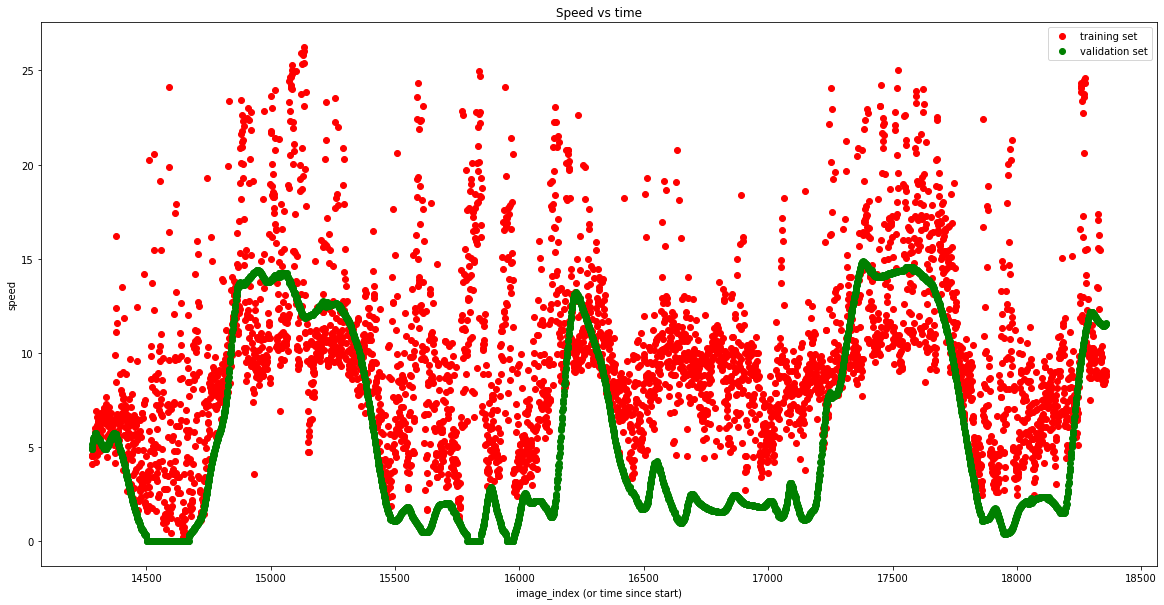

----


40.57474695444462

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(val_ids, preds, 'ro')
plt.plot(val_ids, val_meta['speed'], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
mean_squared_error(val_meta['speed'], preds)

In [50]:
fixed_preds = preds.copy()
bad_preds = [k for k,v in collections.Counter(preds).items() if v > 2]

if fixed_preds[0] in bad_preds:
    for val in fixed_preds[1:]:
        if val not in bad_preds:
            fixed_preds[0] = val
            break
    
for i in range(1, len(fixed_preds)):
    if fixed_preds[i] in bad_preds:
        fixed_preds[i] = fixed_preds[i-1]
    elif fixed_preds[i] < 0:
        fixed_preds[i] = 0
        
        
window = 20
new_preds = fixed_preds[0:window-1]

for i in range(window-1, len(fixed_preds)):
    new_preds += [np.mean(fixed_preds[i-(window-1): i+1])]

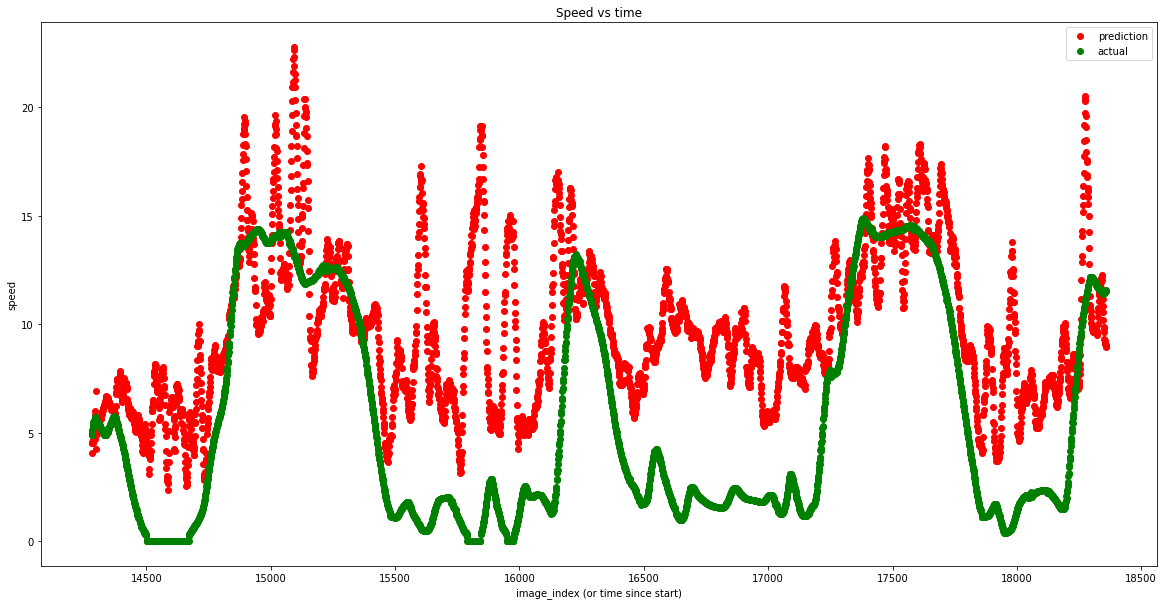

----


31.566588879844137

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(val_ids, new_preds, 'ro', label='prediction')
plt.plot(val_ids, val_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
mean_squared_error(val_meta['speed'], new_preds)

### Holdout Evaluation

In [52]:
holdout_flow = OpticalFlowDataset(HOLDOUT_PATH/'holdout_meta.csv', 
                                  HOLDOUT_PATH,
                                  overwrite_flow = True,
                                  pre_flow_transforms = transforms.Compose([Crop()]),
                                  post_flow_transforms = transforms.Compose([ToTensor(),
                                                                             transforms.Normalize([7.293118, 5.016652, 4.4507527],
                                                                                                  [22.72919, 18.67817, 14.383012])
                                                                            ])
                             )

holdout_dataloader = DataLoader(holdout_flow, batch_size=batch_size, shuffle=False, num_workers=0)

In [53]:
model.eval()
preds = []
for j, data in enumerate(holdout_dataloader, 0):
    with torch.no_grad():
        inputs = data['image']
        labels = data['speed']

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.reshape(outputs.size()[0])
        preds += list(outputs.cpu().numpy())
        
preds.insert(0, preds[1])

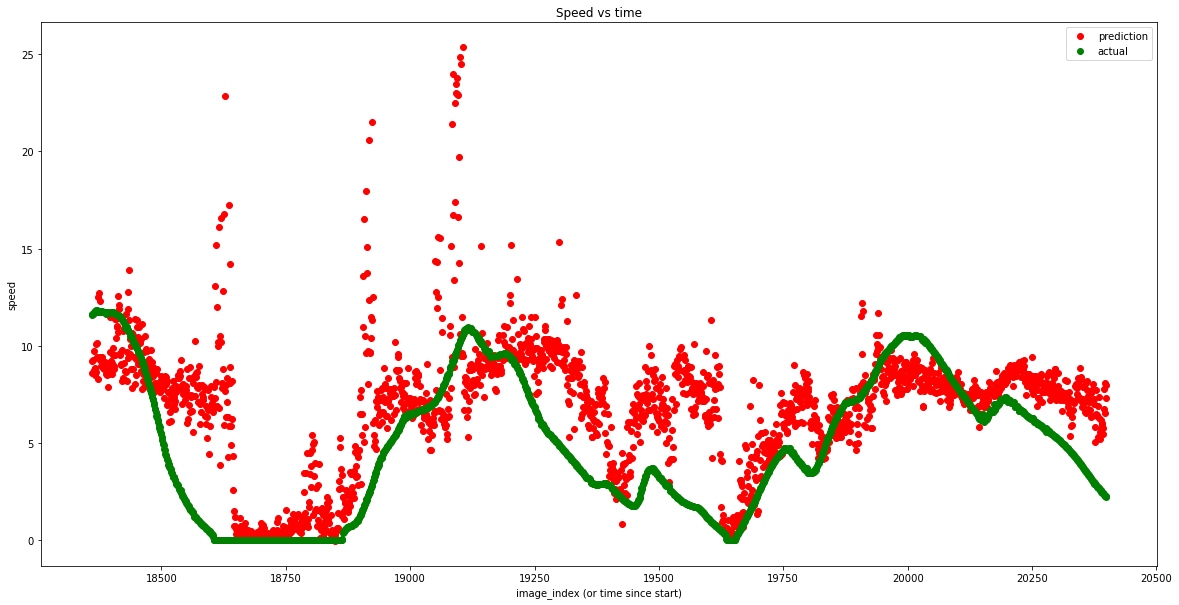

----
mse: 13.075896381572433


In [54]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(holdout_ids, preds, 'ro', label='prediction')
plt.plot(holdout_ids, holdout_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
print(f'mse: {mean_squared_error(holdout_meta["speed"], preds)}')

In [55]:
fixed_preds = preds.copy()
bad_preds = [k for k,v in collections.Counter(preds).items() if v > 2]

if fixed_preds[0] in bad_preds:
    for val in fixed_preds[1:]:
        if val not in bad_preds:
            fixed_preds[0] = val
            break
    
for i in range(1, len(fixed_preds)):
    if fixed_preds[i] in bad_preds:
        fixed_preds[i] = fixed_preds[i-1]
    elif fixed_preds[i] < 0:
        fixed_preds[i] = 0
        
        
window = 30
new_preds = fixed_preds[0:window-1]

for i in range(window-1, len(fixed_preds)):
    new_preds += [np.mean(fixed_preds[i-(window-1): i+1])]

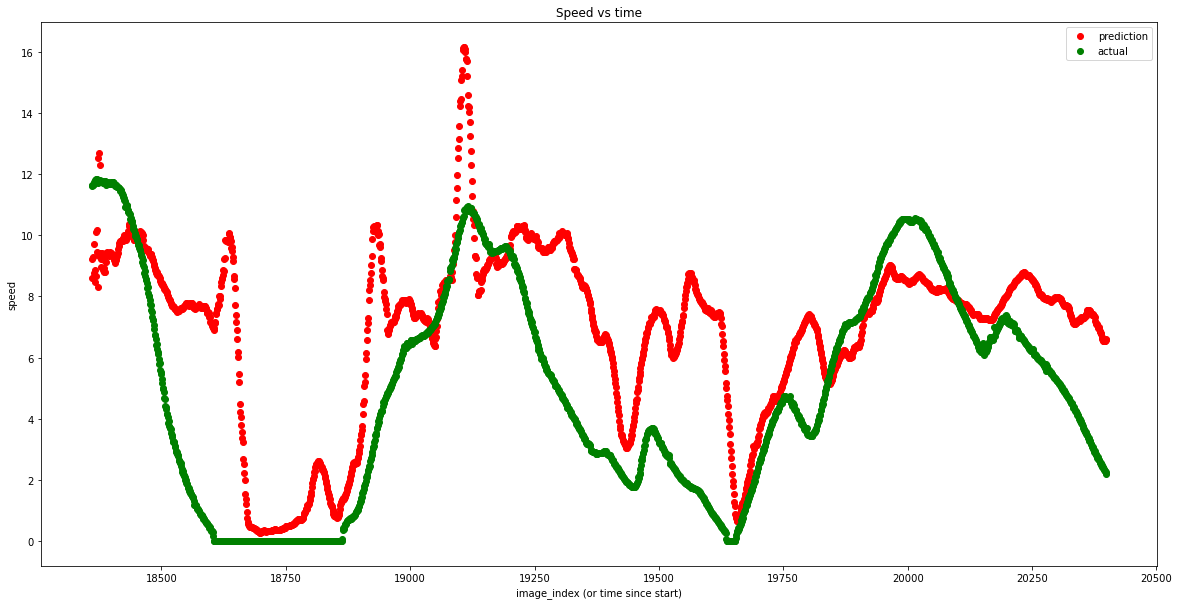

----
mse: 10.668020030736596


In [56]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(holdout_ids, new_preds, 'ro', label='prediction')
plt.plot(holdout_ids, holdout_meta['speed'], 'go', label='actual')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(loc='upper right')
plt.show()
plt.close()

print('----')
print(f'mse: {mean_squared_error(holdout_meta["speed"], new_preds)}')